In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
import seaborn as sns

In [27]:
class LSTM_Forecast:
    def __init__(self,data,num_samples,encoder_n_layers,decoder_layers,encoder_hidden_size,decoder_hidden_size):
        dataset,name,frequency=data
        self.df=dataset
        self.name=name
        self.frequency=frequency
        self.num_samples=num_samples
        self.encoder_n_layers=encoder_n_layers
        self.decoder_layers=decoder_layers
        self.encoder_hidden_size=encoder_hidden_size
        self.decoder_hidden_size=decoder_hidden_size
        self.Y_df = None
        self.Y_train_df = None
        self.Y_test_df = None
        self.train_len = None
       
    @staticmethod
    def create_dataset (self):
        primary = np.array(self.df['y'] ,
            dtype=np.float32,
        )
        finalDF = pd.DataFrame(
            {
                "unique_id": np.ones(len(primary)),
                "ds": self.df['ds'],
                "y": primary,
            }
        )
        return finalDF
    
    def lstm (self):
        self.Y_df = self.create_dataset(self)
        self.Y_train_df = self.Y_df[:int((0.7)*len(self.Y_df))] 
        self.Y_test_df = self.Y_df[int(0.7*len(self.Y_df)):]
        print(len(self.Y_test_df))
        self.train_len=len(self.Y_train_df)
        horizon = len(self.Y_test_df)
        models = [LSTM(h=horizon,input_size=-1,
                 scaler_type='standard',
                 encoder_bias=True,
                 encoder_n_layers=self.encoder_n_layers,
                 encoder_hidden_size=self.encoder_hidden_size,
                 context_size=10,
                 decoder_hidden_size=self.decoder_hidden_size,
                 decoder_layers=self.decoder_layers,
                 max_steps=500,),
                 ]
        nf = NeuralForecast(models=models, freq=self.frequency)
        nf.fit(df=self.Y_train_df)

        output=[]
        for i in range(self.num_samples):
            Y_hat_df = nf.predict().reset_index()
            output.append(Y_hat_df['LSTM'])
        
        return output
    
    def plot(self,output):
        
        out=np.array(output)
        mean_forecasts = np.mean(out,axis=0)
        
        min_forecasts=np.min(out,axis=0)
        max_forecasts=np.max(out,axis=0)
        std_forecasts=np.std(out,axis=0)
        median_forecasts=np.median(out,axis=0)
        print(mean_forecasts.shape,len(min_forecasts),len(max_forecasts))
        plt.figure(figsize=(8,6))

        fig, ax = plt.subplots(figsize = (10, 6))
        mae=[]
        rmse=[]
        plt.axvline(x = self.Y_train_df['ds'][-1:], color = 'black', label = 'train-test split',linestyle='--')
        plt.plot(self.Y_df['ds'],self.Y_df['y'],label='Actual',color='blue')
        plt.plot(self.Y_test_df['ds'][:len(mean_forecasts)],mean_forecasts,label='Mean Forecasts',color='yellow',linestyle='--')
        plt.plot(self.Y_test_df['ds'][:len(min_forecasts)],min_forecasts,color='green',label='Min Forecasts',linestyle='--')
        plt.plot(self.Y_test_df['ds'][:len(max_forecasts)],max_forecasts,color='orange',label='Max Forecasts',linestyle='--')
        plt.plot(self.Y_test_df['ds'][:len(median_forecasts)],median_forecasts,color='red',label='Median Forecasts',linestyle='--')        
        for o in output:
            l=min(len(self.Y_test_df['y']),len(o))
            if l > 0: 
                plt.plot(self.Y_test_df['ds'][:l], o[:l], alpha=0.3, color='lightgray')  
                mae.append(mean_absolute_error(self.Y_test_df['y'][:l], o[:l]))
                rmse.append(np.sqrt(mean_squared_error(self.Y_test_df['y'][:l], o[:l])))

        plt.title(f'LSTM')
        plt.xlabel('Time')
        plt.legend(prop={'size': 15})
        
        ax.text(1,0.5, f'MAE: {np.mean(mae)}\n RMSE: {np.mean(rmse)}\n STD:{np.mean(std_forecasts)}',
            verticalalignment='center',bbox=dict(facecolor='lightgrey', alpha=0.5),transform=ax.transAxes)
        plt.grid(visible=True)
        sns.set_style(style="whitegrid")
        sns.set_palette("husl")
        plt.show()

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


89


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 114 K 
5 | mlp_decoder     | MLP           | 1.5 K 
--------------------------------------------------
315 K     Trainable params
0         Non-trainable params
315 K     Total params
1.262     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


(89,) 89 89


<Figure size 800x600 with 0 Axes>

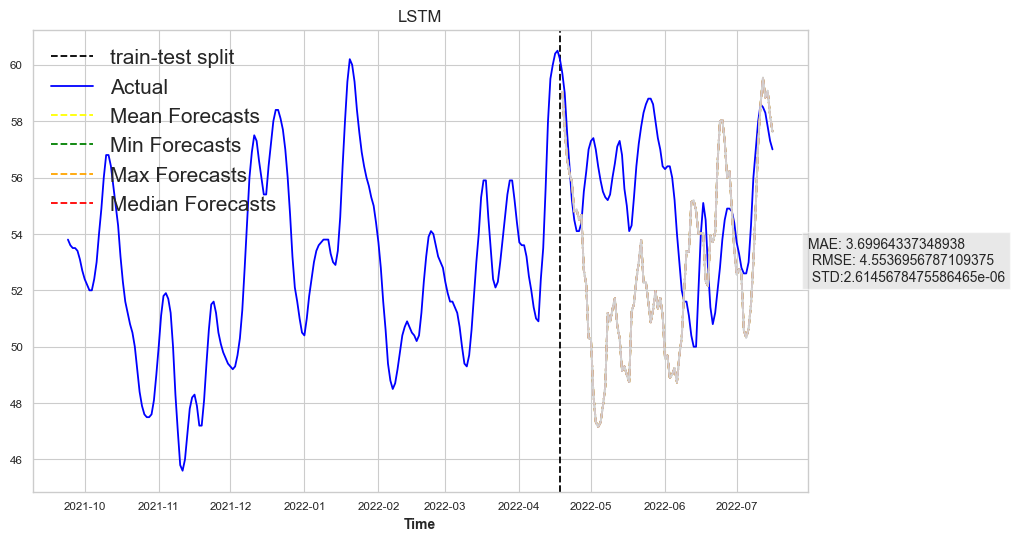

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


150


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 193 K 
5 | mlp_decoder     | MLP           | 1.5 K 
--------------------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.577     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


(150,) 150 150


<Figure size 800x600 with 0 Axes>

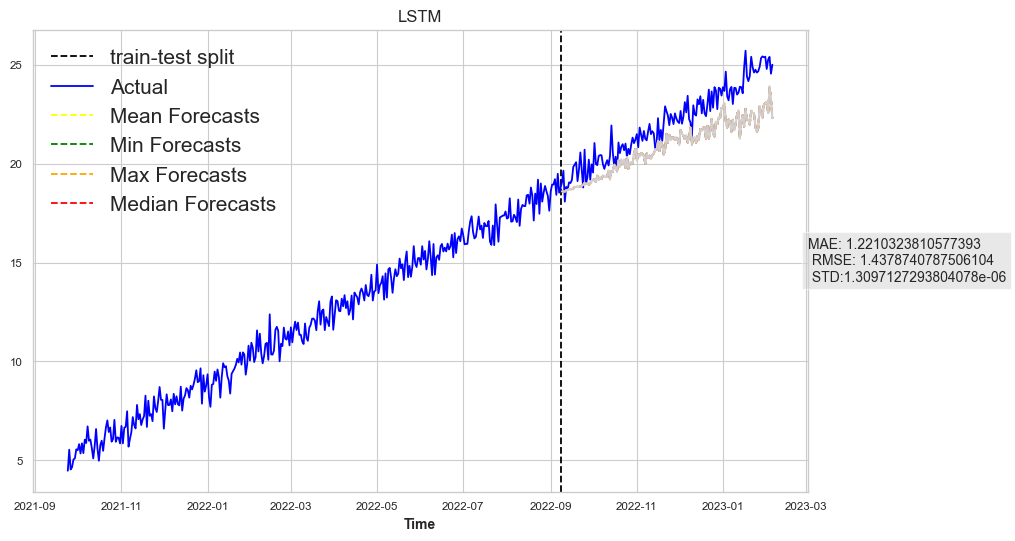

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


150


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 193 K 
5 | mlp_decoder     | MLP           | 1.5 K 
--------------------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.577     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


(150,) 150 150


<Figure size 800x600 with 0 Axes>

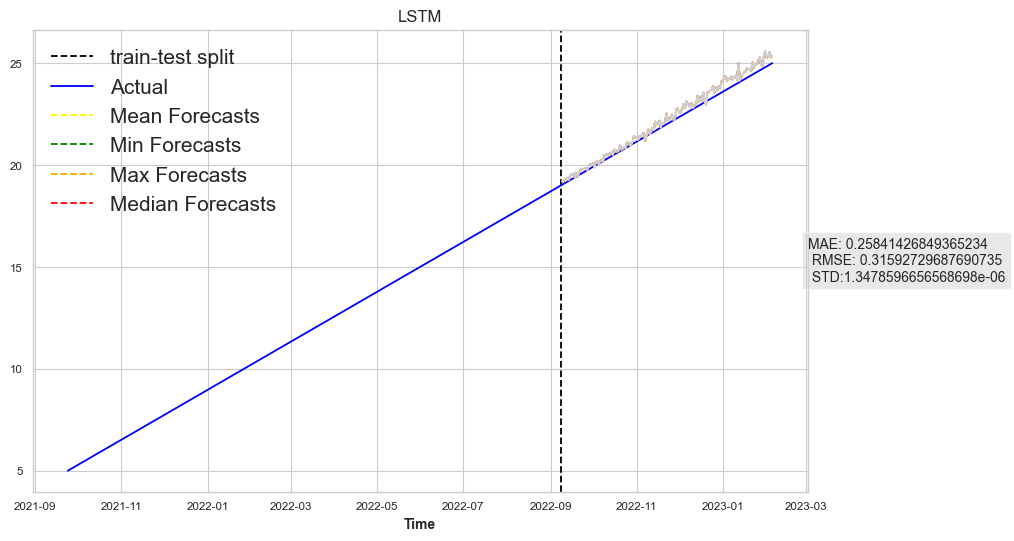

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


300


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 387 K 
5 | mlp_decoder     | MLP           | 1.5 K 
--------------------------------------------------
587 K     Trainable params
0         Non-trainable params
587 K     Total params
2.351     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


(300,) 300 300


<Figure size 800x600 with 0 Axes>

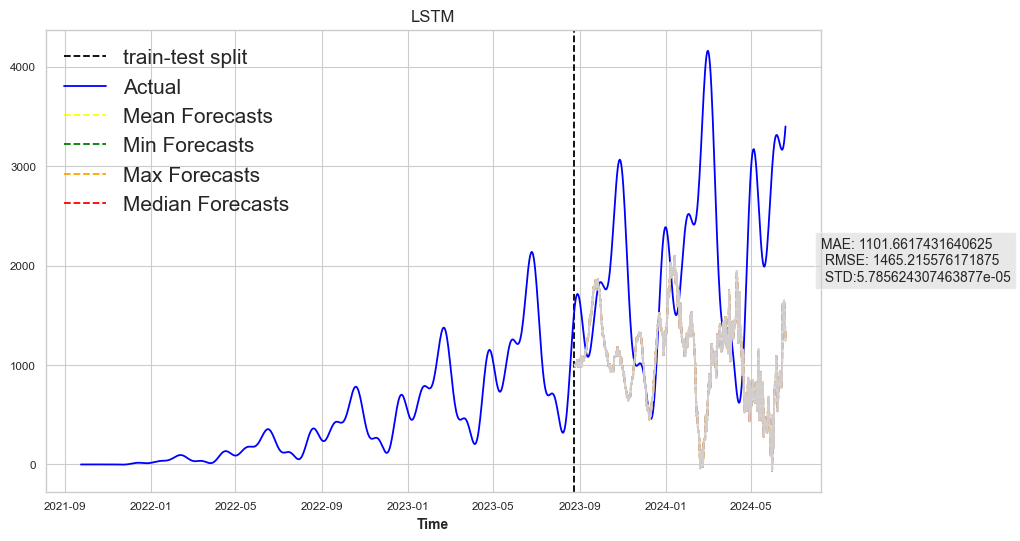

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


150



  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 193 K 
5 | mlp_decoder     | MLP           | 1.5 K 
--------------------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.577     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

(150,) 150 150


c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

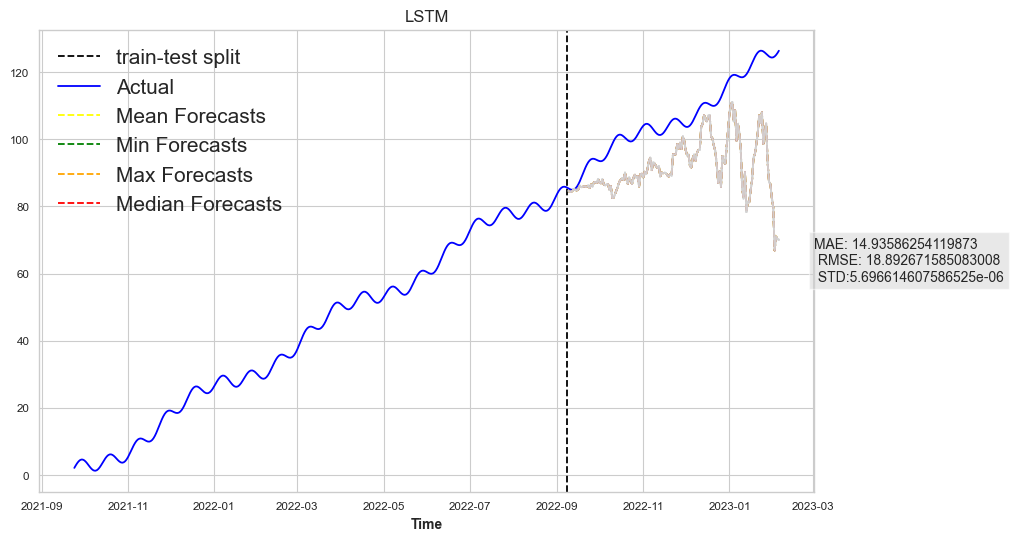

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


150


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 193 K 
5 | mlp_decoder     | MLP           | 1.5 K 
--------------------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.577     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

(150,) 150 150


c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

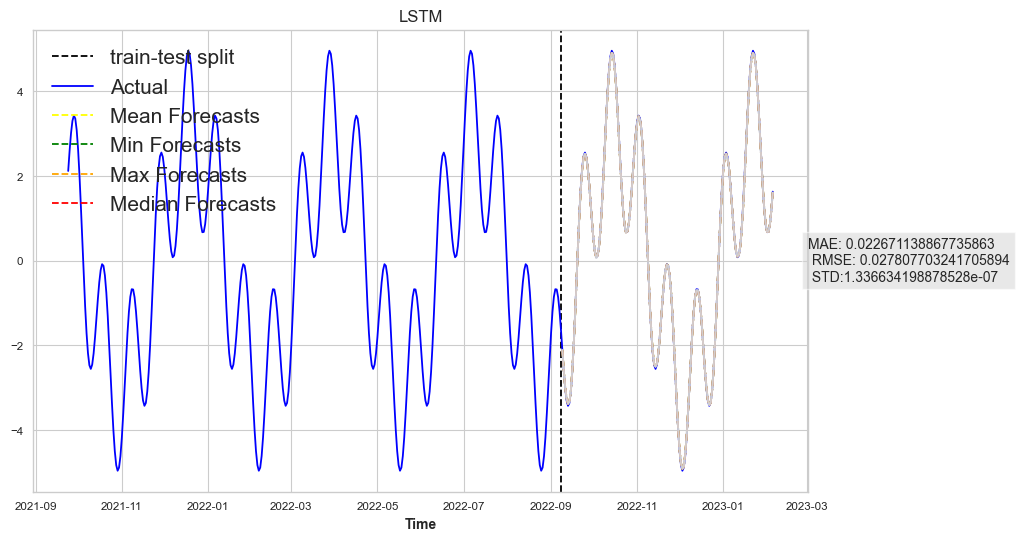

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


150


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 193 K 
5 | mlp_decoder     | MLP           | 1.5 K 
--------------------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.577     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: T

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\hhp40\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


(150,) 150 150


<Figure size 800x600 with 0 Axes>

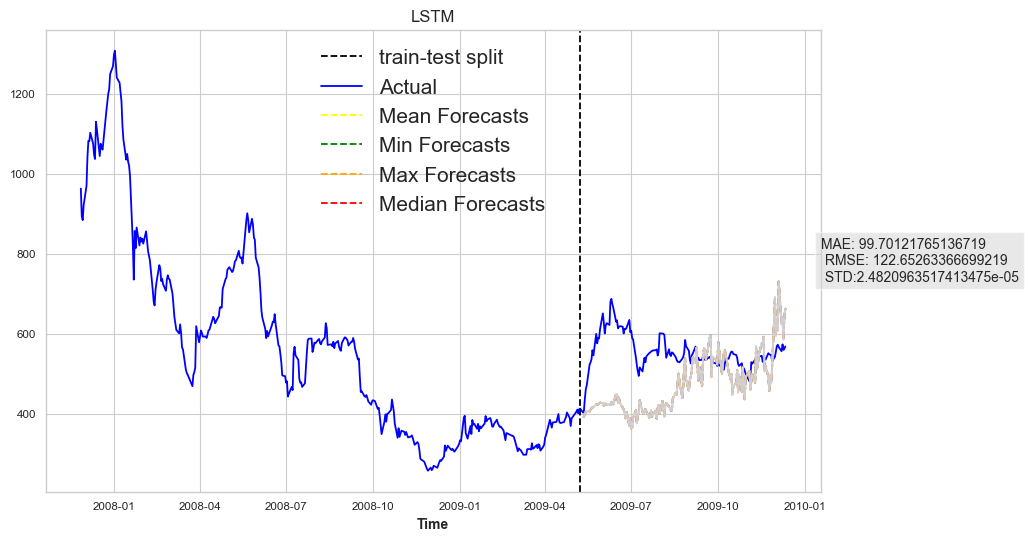

In [28]:
for datas in datasets_names:
    lstm=LSTM_Forecast(datas,10,2,2,128,128)
    output=lstm.lstm()
    lstm.plot(output)

In [14]:
AirPassengersDF

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


In [8]:
import torch
torch.cuda.empty_cache()

In [135]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
co2 = fetch_openml(data_id=41187, as_frame=True, parser='auto')
co2_data = co2.frame
co2_data=pd.DataFrame(co2_data)
co2_data['unique_id']=1.0
 
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data.sort_values(by="date")
co2_data = co2_data[["date", "co2",'unique_id']]
# co2_data['unique_id']=1.0
co2_data['ds']=co2_data['date']
co2_data['y']=co2_data['co2'].astype(np.float32)

co2_data=co2_data.drop(['date','co2'],axis=1)

co2_data=co2_data.squeeze()
train, test = co2_data[:132], co2_data[132:144]
print(train.shape,test.shape,co2_data.shape)
data_name='MaunaLoaCO2'

(132, 3) (12, 3) (2225, 3)


In [173]:
co2_data

,unique_id,ds,y
0,1.0,1958-03-29,316.100006
1,1.0,1958-04-05,317.299988
2,1.0,1958-04-12,317.600006
3,1.0,1958-04-19,317.500000
4,1.0,1958-04-26,316.399994
...,...,...,...
2220,1.0,2001-12-01,370.299988
2221,1.0,2001-12-08,370.799988
2222,1.0,2001-12-15,371.200012
2223,1.0,2001-12-22,371.299988


In [3]:
import darts.datasets
import pandas as pd

dataset_names = [
    'AirPassengersDataset', 
    'AusBeerDataset', 
    'AustralianTourismDataset', 
    'ETTh1Dataset', 
    'ETTh2Dataset', 
    'ETTm1Dataset', 
    'ETTm2Dataset', 
    'ElectricityDataset', 
    'EnergyDataset', 
    'ExchangeRateDataset', 
    'GasRateCO2Dataset', 
    'HeartRateDataset', 
    'ILINetDataset', 
    'IceCreamHeaterDataset', 
    'MonthlyMilkDataset', 
    'MonthlyMilkIncompleteDataset', 
    'SunspotsDataset', 
    'TaylorDataset', 
    'TemperatureDataset',
    'TrafficDataset', 
    'USGasolineDataset', 
    'UberTLCDataset', 
    'WeatherDataset', 
    'WineDataset', 
    'WoolyDataset',
]

def get_descriptions(w_references=False):
    descriptions = []
    for dsname in dataset_names:
        d = getattr(darts.datasets,dsname)().__doc__
        
        if w_references:
            descriptions.append(d)
            continue

        lines = []
        for l in d.split("\n"):
            if l.strip().startswith("References"):
                break
            if l.strip().startswith("Source"):
                break
            if l.strip().startswith("Obtained"):
                break
            lines.append(l)
        
        d = " ".join([x.strip() for x in lines]).strip()

        descriptions.append(d)

    return dict(zip(dataset_names,descriptions))

def get_dataset(dsname):
    darts_ds = getattr(darts.datasets,dsname)().load()
    if dsname=='GasRateCO2Dataset':
        darts_ds = darts_ds[darts_ds.columns[1]]
    series = darts_ds.pd_series()

    if dsname == 'SunspotsDataset':
        series = series.iloc[::4]
    if dsname =='HeartRateDataset':
        series = series.iloc[::2]
    return series

def get_datasets(n=-1,testfrac=0.2):
    datasets = [
        'AirPassengersDataset',
        'AusBeerDataset',
        'GasRateCO2Dataset', # multivariate
        'MonthlyMilkDataset',
        'SunspotsDataset', #very big, need to subsample?
        'WineDataset',
        'WoolyDataset',
        'HeartRateDataset',
    ]
    datas = []
    for i,dsname in enumerate(datasets):
        series = get_dataset(dsname)
        splitpoint = int(len(series)*(1-testfrac))
        
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]
        datas.append((train,test))
        if i+1==n:
            break
    return dict(zip(datasets,datas))

def get_memorization_datasets(n=-1,testfrac=0.15, predict_steps=30):
    datasets = [
        'IstanbulTraffic',
        'TSMCStock',
        'TurkeyPower'
    ]
    datas = []
    for i,dsname in enumerate(datasets):
        with open(f"datasets/memorization/{dsname}.csv") as f:
            series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)
            # treat as float
            series = series.astype(float)
            series = pd.Series(series)
        if predict_steps is not None:
            splitpoint = len(series)-predict_steps
        else:    
            splitpoint = int(len(series)*(1-testfrac))
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]
        datas.append((train,test))
        if i+1==n:
            break
    return dict(zip(datasets,datas))

In [4]:

datasets_names=[]

In [5]:

datasets = get_datasets()
ds_name = 'GasRateCO2Dataset'

data = datasets[ds_name]
data_len=len(data[0])+len(data[1])
print(len(data))
datetime = pd.date_range(start='2021-09-24', periods=data_len, freq='D')
#data=data.set_index(datetime)
train, test = data
train=pd.DataFrame(train)
test=pd.DataFrame(test)
train['unique_id']=1.0
test['unique_id']=1.0
train['ds']=datetime[:len(train)]
test['ds']=datetime[len(train):len(test)+len(train)]
 # or change to your own data
train['y']=train['CO2%']
test['y']=test['CO2%']

train=train.rename_axis(index=None)
test=test.rename_axis(index=None)
train=train.drop(['CO2%'],axis=1)
test=test.drop(['CO2%'],axis=1)
data_name=ds_name
data=pd.concat([train,test],axis=0)
datasets_names.append([data,ds_name,'D'])
print(len(train)+len(test))

2
296


In [60]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
data[0]

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1958-03-01    362.0
1958-04-01    348.0
1958-05-01    363.0
1958-06-01    435.0
1958-07-01    491.0
Freq: MS, Name: #Passengers, Length: 115, dtype: float64

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_points = 500
slope = 2
intercept = 5

# Generate random x values
x_values = np.linspace(0, 10, num_points)
datetime = pd.date_range(start='2021-09-24', periods=len(x_values), freq='D')
# Generate corresponding y values using a linear equation
y_values = slope * x_values + intercept

# Add some noise to y values
noise = np.random.normal(0, 0.5, num_points)
y_values_with_noise = y_values + noise

# Create pandas Series
data = pd.DataFrame({'y':y_values,'ds':datetime})
train, test = data[:int(0.8*len(data))], data[int(0.8*len(data)):]
print(train.shape,test.shape)
datasets_names.append([data,'Linear','D'])

(400, 2) (100, 2)


In [99]:
test

,unique_id,ds,y
236,1.0,2022-05-18,54.3
237,1.0,2022-05-19,55.3
238,1.0,2022-05-20,56.4
239,1.0,2022-05-21,57.2
240,1.0,2022-05-22,57.8
241,1.0,2022-05-23,58.3
242,1.0,2022-05-24,58.6
243,1.0,2022-05-25,58.8
244,1.0,2022-05-26,58.8
245,1.0,2022-05-27,58.6


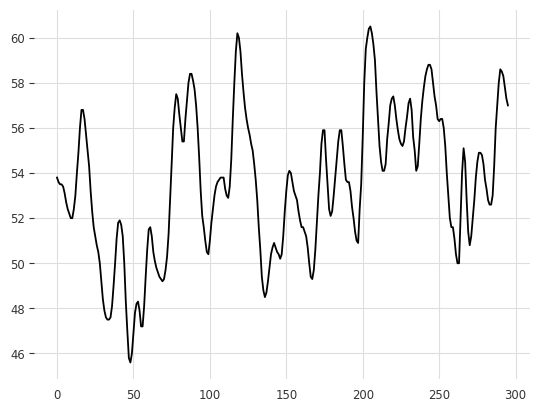

In [104]:
plt.plot(data['y'])

In [100]:
a=np.arange(0,len(data),1)
a
data.set_index(a,inplace=True)
data


,unique_id,ds,y
0,1.0,2021-09-24,53.8
1,1.0,2021-09-25,53.6
2,1.0,2021-09-26,53.5
3,1.0,2021-09-27,53.5
4,1.0,2021-09-28,53.4
...,...,...,...
291,1.0,2022-07-12,58.5
292,1.0,2022-07-13,58.3
293,1.0,2022-07-14,57.8
294,1.0,2022-07-15,57.3


(700, 2) (300, 2)


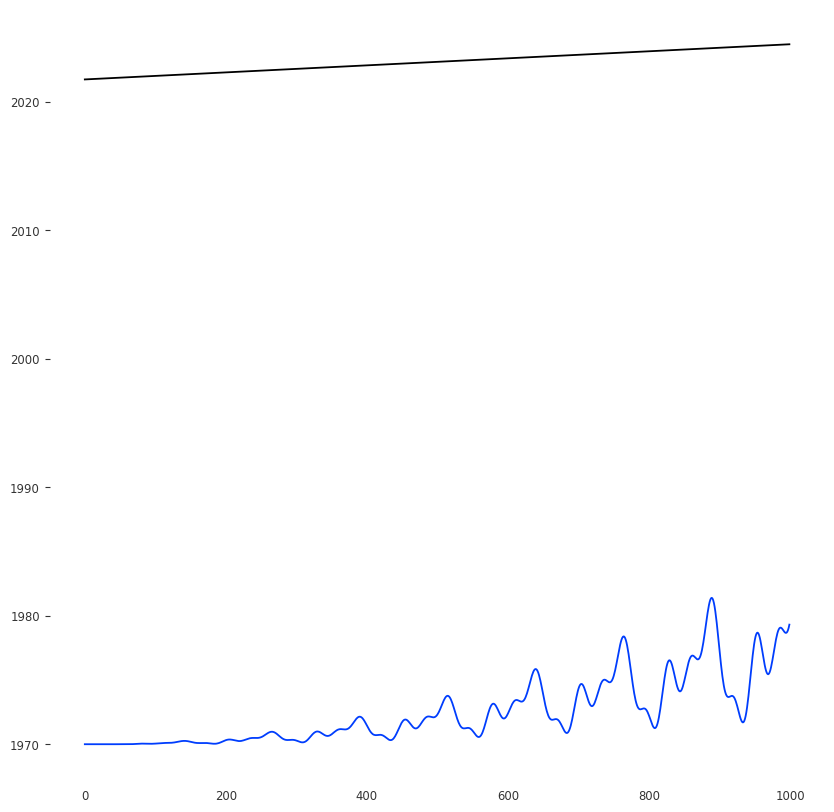

In [8]:
import numpy as np
import pandas as pd
data_name='2(x^2)sin^2(4x)+3(x^2)sin^2(2x+pi/4)+4(x^2)cos^2(x)-3'
def sine_linear(amplitude,frequency,phase,linear,degree,sd,numpoints):
  num_points = numpoints

  # Generate time values from 0 to 2*pi
  t = np.linspace(0, 8*np.pi, num_points)
  curve=0
  date_time = pd.date_range(start='2021-09-24', periods=len(t), freq='D')
  index=np.arange(0,len(t),1)
  # Generate sine wave data
  for i in range(len(amplitude)):
    curve=curve+ ( amplitude[i]*(t**degree[i])*(np.sin((frequency[i] * t)+phase[i])**sd[i]))
  for i in range(len(linear)):
    curve=curve+linear[i]*t
  return pd.DataFrame({'ds': date_time, 'y': curve})


amplitude=[2,3,4]
frequency=[4,2,1]
phase=[0,np.pi/4,np.pi/2]
linear=[-3]
degree=[2,2,2]
sd=[2,2,2]
numpoints=1000
sine_wave_series=sine_linear(amplitude,frequency,phase,linear,degree,sd,numpoints)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(sine_wave_series)
plt.grid()

datasets_names.append([sine_wave_series,"sine-cosine-linear with mutiple degrees",'D'])
train, test = sine_wave_series[:int(0.7*len(sine_wave_series))], sine_wave_series[int(0.7*len(sine_wave_series)):]
print(train.shape,test.shape)

<Axes: title={'center': 'Combined Trigonometric and Linear\xa0Functions'}>

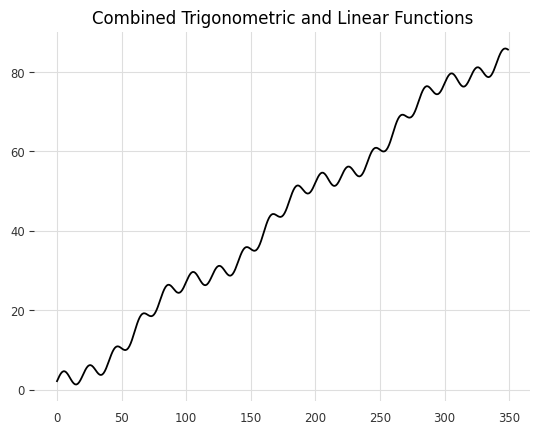

In [9]:
import pandas as pd
import numpy as np

def generate_combined_series(num_points, sine_amplitude=2, cosine_amplitude=3, sine_freq=0.05, cosine_freq=0.01, phase_shift=np.pi/4):
    time_index = np.arange(num_points)
    
    # Generate values for sine and cosine curves
    sine_values = sine_amplitude * np.sin(2 * np.pi * sine_freq * time_index) 
    cosine_values = cosine_amplitude * np.cos(2 * np.pi * cosine_freq * time_index + phase_shift)
    date_time = pd.date_range(start='2021-09-24', periods=len(time_index), freq='D')
    # Generate linear values
    linear_values = 0.25 * time_index
    
    # Combine sine, cosine, and linear values
    combined_values = sine_values + cosine_values + linear_values
    
    # Create pandas series
    combined_series = pd.DataFrame({'y':combined_values,'ds':date_time})
    
    return combined_series

# Number of points for the series
num_points = 500  # Change this as needed

# Generate combined series
combined_series = generate_combined_series(num_points)
datasets_names.append([combined_series,"sine-cosine-linear",'D'])

train, test = combined_series[:int(0.7*len(combined_series))], combined_series[int(0.7*len(combined_series)):]
train['y'].plot(title="Combined Trigonometric and Linear Functions")

In [16]:
test

,ds,y
700,2023-08-25,1579.564777
701,2023-08-26,1636.638237
702,2023-08-27,1678.446350
703,2023-08-28,1704.290621
704,2023-08-29,1714.020349
...,...,...
995,2024-06-15,3170.061456
996,2024-06-16,3194.803843
997,2024-06-17,3240.224167
998,2024-06-18,3307.959933


In [41]:
MaunaLoaDF


,unique_id,ds,y
0,1.0,2007-11-27,962.900024
1,1.0,2007-11-28,893.900024
2,1.0,2007-11-29,884.200012
3,1.0,2007-11-30,921.549988
4,1.0,2007-12-03,969.299988
...,...,...,...
495,1.0,2009-12-07,556.599976
496,1.0,2009-12-08,573.750000
497,1.0,2009-12-09,559.950012
498,1.0,2009-12-10,563.250000


<Axes: title={'center': 'Combined Sine and\xa0Cosine\xa0Curves'}>

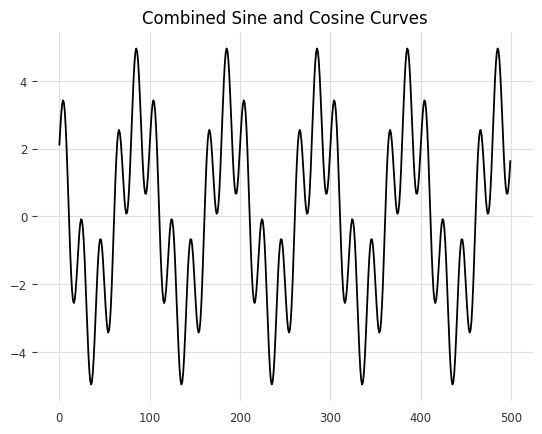

In [10]:
import pandas as pd
import numpy as np

def generate_combined_series(num_points, sine_amplitude=2, cosine_amplitude=3, sine_freq=0.05, cosine_freq=0.01, phase_shift=np.pi/4):
    # Generate values for sine and cosine curves
    time_index = np.arange(num_points)
    sine_values = sine_amplitude * np.sin(2 * np.pi * sine_freq * time_index) 
    cosine_values = cosine_amplitude * np.cos(2 * np.pi * cosine_freq * time_index + phase_shift)
    date_time = pd.date_range(start='2021-09-24', periods=len(time_index), freq='D')
    index=np.arange(0,len(time_index),1)

    # Create pandas series combining sine and cosine curves
    combined_values = sine_values + cosine_values
    combined_series = pd.Series(combined_values)

    return pd.DataFrame({'ds': date_time, 'y': combined_values})

# Number of points for the series
num_points = 500  # Change this as needed

# Generate combined series
combined_series = generate_combined_series(num_points)
datasets_names.append([combined_series,"sine-cosine-linear 2",'D'])
# Plot the combined series
combined_series['y'].plot(title="Combined Sine and Cosine Curves")

In [26]:
import numpy as np
import pandas as pd

# Number of points
num_points = 1000

# Generate time values from 0 to 2*pi
t = np.linspace(0, 2*np.pi, num_points)

# Generate sine wave data
amplitude = 1  # Amplitude of the sine wave
frequency = 4  # Frequency of the sine wavea
sine_wave = amplitude * np.sin(frequency * t) + amplitude
date_time = pd.date_range(start='2021-09-24', periods=len(t), freq='D')
# Create a Pandas Series
sine_wave_series = pd.DataFrame({'y': sine_wave,'ds':date_time})

# Display the first few points of the series
datasets_names.append([sine_wave_series,"sine-linear",'D'])
# Display the Series
train, test = sine_wave_series[:int(0.7*len(sine_wave_series))], sine_wave_series[int(0.7*len(sine_wave_series)):]
print(train.shape,test.shape)

(700, 2) (300, 2)


In [11]:
import pandas as pd
df=pd.read_csv('C:/Users/hhp40/Downloads/NIFTY50_all.csv')

In [33]:
df['Close'][0:500]

0      962.90
1      893.90
2      884.20
3      921.55
4      969.30
        ...  
495    556.60
496    573.75
497    559.95
498    563.25
499    568.55
Name: Close, Length: 500, dtype: float64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                235192 non-null  object 
 1   Symbol              235192 non-null  object 
 2   Series              235192 non-null  object 
 3   Prev Close          235192 non-null  float64
 4   Open                235192 non-null  float64
 5   High                235192 non-null  float64
 6   Low                 235192 non-null  float64
 7   Last                235192 non-null  float64
 8   Close               235192 non-null  float64
 9   VWAP                235192 non-null  float64
 10  Volume              235192 non-null  int64  
 11  Turnover            235192 non-null  float64
 12  Trades              120344 non-null  float64
 13  Deliverable Volume  219115 non-null  float64
 14  %Deliverble         219115 non-null  float64
dtypes: float64(11), int64(1), object(3

In [36]:
df['Date']

0         2007-11-27
1         2007-11-28
2         2007-11-29
3         2007-11-30
4         2007-12-03
             ...    
235187    2021-04-26
235188    2021-04-27
235189    2021-04-28
235190    2021-04-29
235191    2021-04-30
Name: Date, Length: 235192, dtype: object

In [12]:
df['Date']=pd.to_datetime(df['Date'])

In [38]:
df['Date']

0        2007-11-27
1        2007-11-28
2        2007-11-29
3        2007-11-30
4        2007-12-03
            ...    
235187   2021-04-26
235188   2021-04-27
235189   2021-04-28
235190   2021-04-29
235191   2021-04-30
Name: Date, Length: 235192, dtype: datetime64[ns]

In [29]:
datasets_names

[[     unique_id         ds     y
  0          1.0 2021-09-24  53.8
  1          1.0 2021-09-25  53.6
  2          1.0 2021-09-26  53.5
  3          1.0 2021-09-27  53.5
  4          1.0 2021-09-28  53.4
  ..         ...        ...   ...
  291        1.0 2022-07-12  58.5
  292        1.0 2022-07-13  58.3
  293        1.0 2022-07-14  57.8
  294        1.0 2022-07-15  57.3
  295        1.0 2022-07-16  57.0
  
  [296 rows x 3 columns],
  'GasRateCO2Dataset',
  'D'],
 [             y         ds
  0     5.650612 2021-09-24
  1     4.883884 2021-09-25
  2     4.944546 2021-09-26
  3     6.051697 2021-09-27
  4     4.838884 2021-09-28
  ..         ...        ...
  495  24.933971 2023-02-01
  496  25.160219 2023-02-02
  497  24.459010 2023-02-03
  498  25.283607 2023-02-04
  499  25.693413 2023-02-05
  
  [500 rows x 2 columns],
  'Linear with noise',
  'D'],
 [            ds            y
  0   2021-09-24     0.000000
  1   2021-09-25    -0.071886
  2   2021-09-26    -0.136087
  3   2021-09-27

In [14]:
data=pd.DataFrame({'y':df['Close'][0:500],'ds':df['Date'][0:500]})
datasets_names.append([data,"Nifty50",'D'])


In [47]:
for i in range (9):
    print(datasets_names[i][1])

GasRateCO2Dataset
Linear
Linear with noise
sine-cosine-linear with mutiple degrees
sine-cosine-linear with mutiple degrees
sine-cosine-linear
sine-cosine-linear 2
sine-linear
Nifty50
